In [22]:
import os, json, math, random
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import functools
from datetime import datetime, timedelta
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from tensorflow.keras.layers import (
    Input, LSTM, Dense, GlobalAveragePooling1D, Concatenate, Add, Softmax,
    BatchNormalization, Multiply, Layer, Dropout, Reshape, LayerNormalization, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import register_keras_serializable
from time import perf_counter

In [ ]:
# Data preprocessing
# Time parsing
DTFMT = "%d-%m-%Y %H:%M:%S"
DTFMT_CANDIDATES = [
    DTFMT,
    "%d-%m-%Y %H:%M",
    "%Y-%m-%d %H:%M:%S",
    "%m/%d/%Y %H:%M:%S",
]

FREQ = "5min"                 # resample frequency
CGM_SHORT_GAP_LIMIT = 12      # max CGM gap length for interpolation (<= 60 min)
CGM_LONG_GAP_DAY_DROP = 24   # drop day if longest CGM gap >= 120 min
CONT_SHORT_GAP_LIMIT = 6      # max non-CGM gap length for interpolation
WINSOR_Q = (0.01, 0.99)       # winsorization quantiles
GLUCOSE_CLIP = (40, 400)     # physiologic glucose range

# On-board kernels 生理模型参数
COB_GAMMA_A    = 3.0
COB_THETA_MIN  = 15.0
COB_TOTAL_MIN  = 240

IOB_GAMMA_A    = 3.0
IOB_THETA_MIN  = 30.0
IOB_TOTAL_MIN  = 360

AOB_GAMMA_A    = 2.0
AOB_THETA_MIN  = 60.0
AOB_TOTAL_MIN  = 720

# Use AOB to overwrite exercise_intensity
USE_AOB_FOR_EXERCISE = True

# Utils  时间与数据处理工具函数
# 尝试多种格式将字符串解析为 pandas 时间戳
def safe_to_dt(ts):
    if ts is None:
        return pd.NaT
    for fmt in DTFMT_CANDIDATES:
        try:
            return pd.to_datetime(ts, format=fmt, dayfirst=True)
        except Exception:
            continue
    return pd.to_datetime(ts, errors="coerce", dayfirst=True)

# 尝试将任意值转换为 float
def safe_float(v, default=np.nan):
    try:
        return float(v) if v is not None and str(v).strip() != "" else default
    except Exception:
        return default

# 按分位数上下截断异常值
def winsorize_series(s: pd.Series, lower=WINSOR_Q[0], upper=WINSOR_Q[1]):
    s = s.copy()
    if s.notna().sum() == 0:
        return s
    ql, qu = s.quantile([lower, upper])
    return s.clip(ql, qu)

# 返回 series 中最长连续 NaN 段长度 (Return longest consecutive NaN run length
def longest_nan_run(s: pd.Series) -> int:
    x = s.isna().to_numpy()
    if not x.any():
        return 0
    max_len = 0
    cur = 0
    for v in x:
        if v:
            cur += 1
            if cur > max_len:
                max_len = cur
        else:
            cur = 0
    return int(max_len)

# On-board calculations (Gamma 卷积核构造 + 卷积运算
# 使用预定义的 Gamma分布形状的卷积核（gamma kernel），对输入信号进行因果卷积（causal convolution），来模拟这些事件对血糖的影响是延迟且逐渐衰减的。
@functools.lru_cache(maxsize=16)
def make_gamma_kernel(total_min=240, step_min=5, a=3.0, theta_min=15.0, zero_at_t0=True):
    #构造 Gamma分布形状的核（如 COB/IOB） (Build discrete causal gamma kernel, returns shape (L,) and sums to 1, zero_at_t0=True sets k[0]=0

    L = int(total_min // step_min) + 1
    t = np.arange(L, dtype=np.float32) * step_min
    k = (np.power(np.clip(t, 1e-6, None), a - 1.0) * np.exp(-t / theta_min)).astype(np.float32)
    if zero_at_t0:
        k[0] = 0.0
    s = k.sum()
    if s > 0:
        k = k / s
    return k.astype(np.float32)

# 将输入序列与核做因果卷积，忽略 NaN
def causal_convolve(x: np.ndarray, k: np.ndarray):
    if x.ndim != 1:
        x = x.reshape(-1)
    x = np.nan_to_num(x.astype(np.float32), nan=0.0)
    y_full = np.convolve(x, k.astype(np.float32), mode="full")
    return y_full[: len(x)].astype(np.float32)

# XML parsing 这些函数主要从 XML 节点提取特定模态数据，并返回 timestamp + value 的 DataFrame
# 通用的 XML 模态数据解析器，提取按时间记录的连续数值型模态数据
def parse_single_timestamp_modal(root, tag, attr="value", time_attr="ts"):
    data = []
    for elem in root.findall(f"./{tag}/event"):
        t = elem.attrib.get(time_attr)
        v = elem.attrib.get(attr)
        if t and v:
            dt = safe_to_dt(t)
            fv = safe_float(v)
            if pd.notna(dt) and pd.notna(fv):
                data.append((dt, fv))
    return pd.DataFrame(data, columns=["timestamp", tag])

def parse_bolus(root):
    rows = []
    for e in root.findall("./bolus/event"):
        t = e.attrib.get("ts_begin") or e.attrib.get("ts")
        dose = e.attrib.get("dose")
        if t and dose:
            dt = safe_to_dt(t)
            d = safe_float(dose, 0.0)
            if pd.notna(dt) and pd.notna(d):
                rows.append((dt, d))
    return pd.DataFrame(rows, columns=["timestamp", "bolus_dose"]) \
        if rows else pd.DataFrame(columns=["timestamp", "bolus_dose"])

def parse_meal(root):
    rows = []
    for e in root.findall("./meal/event"):
        t = e.attrib.get("ts")
        carbs = e.attrib.get("carbs")
        if t and carbs:
            dt = safe_to_dt(t)
            c = safe_float(carbs)
            if pd.notna(dt) and pd.notna(c):
                rows.append((dt, c))
    return pd.DataFrame(rows, columns=["timestamp", "meal_carbs"]) if rows else pd.DataFrame(columns=["timestamp","meal_carbs"])

# 从 <basal> 和 <temp_basal> 中分别提取：
# 正常基础胰岛素注射速率（rate），在给定时间点发生变化；普通 basal 速率，每当数值变更，记录一次
# 临时基础速率（temp basal），覆盖正常速率一定时间段；临时 basal：用于短时覆盖原速率
# basal_df和temp_df会在后续被合并为一条最终基础胰岛素注射时间序列（即 basal），然后作为 insulin_basal 特征输入。
def parse_basal(root):
    base_rows = []
    for e in root.findall("./basal/event"):
        t = e.attrib.get("ts")
        v = e.attrib.get("value") or e.attrib.get("rate")
        if t and v:
            dt = safe_to_dt(t)
            val = safe_float(v)
            if pd.notna(dt) and pd.notna(val):
                base_rows.append((dt, val))
    basal_df = pd.DataFrame(base_rows, columns=["timestamp","rate"]).sort_values("timestamp") if base_rows else pd.DataFrame(columns=["timestamp","rate"])

    temp_rows = []
    for e in root.findall("./temp_basal/event"):
        t = e.attrib.get("ts")
        rate = e.attrib.get("rate") or e.attrib.get("value")
        dur = e.attrib.get("duration")
        if t and rate:
            dt = safe_to_dt(t)
            r = safe_float(rate)
            dmin = int(float(dur)) if dur is not None and str(dur).strip() != "" else None
            if pd.notna(dt) and pd.notna(r):
                temp_rows.append((dt, r, dmin))
    temp_df = pd.DataFrame(temp_rows, columns=["ts","rate","duration"]).sort_values("ts") if temp_rows else pd.DataFrame(columns=["ts","rate","duration"])

    return basal_df, temp_df

# Main preprocessing---------
def preprocess_xml_to_dataframe(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Read by modality
    modal_funcs = {
        "glucose_level": parse_single_timestamp_modal,
        "basis_heart_rate": parse_single_timestamp_modal,
        "basis_gsr": parse_single_timestamp_modal,
        "basis_skin_temperature": parse_single_timestamp_modal,
        "basis_steps": parse_single_timestamp_modal,
        "acceleration": parse_single_timestamp_modal,
        "bolus": parse_bolus,
        "meal": parse_meal,
        "basal_all": parse_basal,
    }

    modal_data = {}
    for key, func in modal_funcs.items():
        if key in ["bolus", "meal"]:
            modal_data[key] = func(root)
        elif key == "basal_all":
            modal_data[key] = func(root)
        else:
            modal_data[key] = func(root, key)

    # Build time range
    valid_times = []
    for df_ in modal_data.values():
        if isinstance(df_, tuple):
            for sub in df_:
                if isinstance(sub, pd.DataFrame) and not sub.empty and "timestamp" in sub.columns:
                    valid_times.append(sub["timestamp"])
        elif isinstance(df_, pd.DataFrame) and not df_.empty and "timestamp" in df_.columns:
            valid_times.append(df_["timestamp"])
    if len(valid_times) == 0:
        raise ValueError(f"{os.path.basename(xml_path)} has no valid timestamps")

    all_times = pd.concat(valid_times)
    start_time = pd.to_datetime(all_times.min()).floor(FREQ)
    end_time   = pd.to_datetime(all_times.max()).ceil(FREQ)
    full_index = pd.date_range(start=start_time, end=end_time, freq=FREQ)

    df = pd.DataFrame(index=full_index)

    # Continuous signals resampled by mean
    cont_keys = [
        "glucose_level",
        "basis_heart_rate",
        "basis_gsr",
        "basis_skin_temperature",
        "basis_steps",
        "acceleration",
    ]
    for key in cont_keys:
        data = modal_data.get(key)
        if isinstance(data, pd.DataFrame) and not data.empty:
            s = data.set_index("timestamp")[key].resample(FREQ).mean()
            df[key] = s.reindex(full_index)

    # For events bolus and meal
    if isinstance(modal_data.get("bolus"), pd.DataFrame) and not modal_data["bolus"].empty:
        s = modal_data["bolus"].set_index("timestamp")["bolus_dose"].resample(FREQ).sum().fillna(0)
        df["bolus_event"] = s.reindex(full_index).fillna(0)
    else:
        df["bolus_event"] = 0.0

    if isinstance(modal_data.get("meal"), pd.DataFrame) and not modal_data["meal"].empty:
        s = modal_data["meal"].set_index("timestamp")["meal_carbs"].resample(FREQ).sum().fillna(0)
        df["meal_event"] = s.reindex(full_index).fillna(0)
    else:
        df["meal_event"] = 0.0

    # Basal with temp overrides
    basal_df, temp_df = modal_data.get("basal_all", (pd.DataFrame(), pd.DataFrame()))
    if isinstance(basal_df, pd.DataFrame) and not basal_df.empty:
        basal_s = basal_df.set_index("timestamp")["rate"].sort_index().reindex(full_index).ffill()
    else:
        basal_s = pd.Series(index=full_index, dtype=float)

    if isinstance(temp_df, pd.DataFrame) and not temp_df.empty:
        temp_rate = pd.Series(index=full_index, dtype=float)
        freq_off = pd.tseries.frequencies.to_offset(FREQ)
        for _, r in temp_df.iterrows():
            ts = r["ts"]; rate = r["rate"]; dur = r.get("duration")
            if pd.isna(ts) or pd.isna(rate):
                continue
            start = pd.to_datetime(ts).floor(FREQ)
            if dur is None or pd.isna(dur):
                end = full_index.max() + freq_off
            else:
                end = start + pd.Timedelta(minutes=int(dur))
            mask = (full_index >= start) & (full_index < end)
            temp_rate.loc[mask] = float(rate)
        basal = basal_s.copy()
        basal.loc[~temp_rate.isna()] = temp_rate.dropna()
        df["basal"] = basal
    else:
        df["basal"] = basal_s

    # On-board features: COB and IOB
    cob_k = make_gamma_kernel(total_min=COB_TOTAL_MIN, step_min=5, a=COB_GAMMA_A, theta_min=COB_THETA_MIN)
    iob_k = make_gamma_kernel(total_min=IOB_TOTAL_MIN, step_min=5, a=IOB_GAMMA_A, theta_min=IOB_THETA_MIN)

    df["meal_cob"]   = causal_convolve(df["meal_event"].values,  cob_k)
    df["iob_bolus"]  = causal_convolve(df["bolus_event"].values, iob_k)

    # Columns for model
    df["meal_carbs"]  = df["meal_cob"]
    df["bolus_dose"]  = df["iob_bolus"]

    # CGM gap handling
    if "glucose_level" in df.columns:
        g = df["glucose_level"].copy()
        # drop days with long gaps
        to_drop = []
        for day, seg in g.groupby(g.index.date):
            L = longest_nan_run(seg)
            if L >= CGM_LONG_GAP_DAY_DROP:
                to_drop.append(pd.Timestamp(day))
        if len(to_drop) > 0:
            drop_idx = df.index.normalize().isin(to_drop)
            df = df.loc[~drop_idx]
            g = df["glucose_level"].copy()
        # short gaps interpolation, then physiologic clip
        g = g.interpolate(method="time", limit=CGM_SHORT_GAP_LIMIT, limit_direction="forward")
        g = g.clip(lower=GLUCOSE_CLIP[0], upper=GLUCOSE_CLIP[1])
        df["glucose_level"] = g

    # Other modalities interpolation
    for c in ["basis_heart_rate", "basis_skin_temperature", "acceleration"]:
        if c in df.columns:
            df[c] = df[c].interpolate(method="time", limit=CONT_SHORT_GAP_LIMIT, limit_direction="forward")

    if "basis_gsr" in df.columns:
        df["basis_gsr"] = winsorize_series(df["basis_gsr"]) \
            .interpolate(method="time", limit=CONT_SHORT_GAP_LIMIT, limit_direction="forward")

    if "basis_steps" in df.columns:
        df["basis_steps"] = df["basis_steps"].fillna(0)

    # mask and delta
    md_cols = [c for c in [
        "glucose_level","basis_heart_rate","basis_gsr","basis_skin_temperature","acceleration","basis_steps","basal"
    ] if c in df.columns]

    return df

# Standard 7 columns
TARGET_COLS = [
    "glucose","meal_carbs","insulin_bolus","insulin_basal",
    "exercise_intensity","gsr","skin_temp"
]

# 映射原始 df 为标准 7 列，并处理运动强度
# 重点理解的是：
# exercise_intensity 来源于 steps 优先，其次 acceleration
# 做了归一化 + 中值滤波 + AOB 延迟卷积模拟运动对血糖影响
def to_target_schema(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(index=df_raw.index)
    df["glucose"] = df_raw.get("glucose_level")

    # processed features (COB/IOB)
    df["meal_carbs"]    = df_raw.get("meal_carbs", 0.0)
    df["insulin_bolus"] = df_raw.get("bolus_dose", 0.0)
    df["insulin_basal"] = df_raw.get("basal")

    # keep raw events
    df["meal_event"]  = df_raw.get("meal_event", 0.0)
    df["bolus_event"] = df_raw.get("bolus_event", 0.0)

    # exercise_intensity: first steps, else acceleration; clip, normalize, smooth; optional AOB
    a = None
    if "basis_steps" in df_raw.columns and df_raw["basis_steps"].notna().any():
        a = df_raw["basis_steps"].astype(float)
    elif "acceleration" in df_raw.columns and df_raw["acceleration"].notna().any():
        a = df_raw["acceleration"].astype(float)
    if a is None:
        a = pd.Series(index=df_raw.index, dtype=float)
    if a.notna().any():
        a = a.clip(upper=a.quantile(0.95))
        vmax = a.max()
        if pd.notna(vmax) and vmax > 0:
            a = a / vmax
        a = a.rolling(window=3, min_periods=1).median()

    if USE_AOB_FOR_EXERCISE:
        a_k = make_gamma_kernel(total_min=AOB_TOTAL_MIN, step_min=5, a=AOB_GAMMA_A, theta_min=AOB_THETA_MIN, zero_at_t0=False)
        aob = causal_convolve(np.nan_to_num(a.values, nan=0.0), a_k)
        df["exercise_intensity"] = pd.Series(aob, index=df_raw.index)
        df["exercise_raw"] = a
    else:
        df["exercise_intensity"] = a

    df["gsr"] = df_raw.get("basis_gsr")
    df["skin_temp"] = df_raw.get("basis_skin_temperature")

    df = df.sort_index()
    df = df[~df.index.duplicated(keep="first")]
    return df

# 简单缺失值填充器（前向填充 + 中位数兜底）
def impute_target_7cols(df7: pd.DataFrame, limit_steps: int = 6) -> pd.DataFrame:
    """
    light imputation:
      events: fill 0 (meal_carbs, insulin_bolus) which are COB/IOB;
      continuous: forward fill with limit, then fill remaining NaN with median
    """
    df7 = df7.copy()

    for c in ["meal_carbs","insulin_bolus"]:
        if c in df7.columns:
            df7[c] = df7[c].fillna(0)

    for c in ["insulin_basal","exercise_intensity","gsr","skin_temp","glucose"]:
        if c in df7.columns:
            s = df7[c]
            s = s.ffill(limit=limit_steps)
            if s.isna().any():
                med = float(np.nanmedian(s.values)) if np.isfinite(np.nanmedian(s.values)) else 0.0
                s = s.fillna(med)
            df7[c] = s
    return df7

# Normalization (计算每列的 mean/std 并保存
def compute_scaler(df, cols):
    stats = {}
    for c in cols:
        x = df[c].astype(float).values
        m = np.nanmean(x); s = np.nanstd(x)
        if not np.isfinite(m): m = 0.0
        if not np.isfinite(s) or s == 0: s = 1.0
        stats[c] = {"mean": float(m), "std": float(s)}
    return stats

# 将数据标准化并添加 *_norm 列
def apply_scaler(df, stats):
    df_std = df.copy()
    for c, st in stats.items():
        df_std[c+"_norm"] = (df[c] - st["mean"]) / st["std"]
    return df_std

# 统计每一列非缺失值（non-null）的占比
def summarize_nonnull(df7: pd.DataFrame):
    pct = df7.notna().mean().rename("nonnull_ratio").map(lambda x: f"{x*100:.1f}%")
    return pct

# 对一组患者的 XML 数据文件（train/test）进行批量预处理和保存
# 清洗、对齐、插值、构造模型输入特征、标准化，然后保存为 csv、npy 和标准化参数 json
def _process_split(split_dir, out_dir, scaler_dir, is_train: bool):
    files = sorted([f for f in os.listdir(split_dir) if f.endswith(".xml")])
    split_name = os.path.basename(split_dir)
    print(f"Found {split_name}={len(files)} XML")

    for f in files:
        pid = f.split("-")[0]
        xmlp = os.path.join(split_dir, f)
        role = "train" if is_train else "test"
        try:
            df_raw = preprocess_xml_to_dataframe(xmlp)
            df7 = to_target_schema(df_raw)
            full_idx = pd.date_range(df7.index.min(), df7.index.max(), freq=FREQ)
            df7 = df7.reindex(full_idx)

            # missingness before imputation
            print(f"[{role} {pid}] Missingness before imputation:")
            print(summarize_nonnull(df7[TARGET_COLS]).to_string())

            df7 = impute_target_7cols(df7)

            scaler_path = os.path.join(scaler_dir, f"{pid}_scaler.json")
            if is_train or not os.path.exists(scaler_path):
                stats = compute_scaler(df7, TARGET_COLS)
                os.makedirs(scaler_dir, exist_ok=True)
                with open(scaler_path, "w") as fp:
                    json.dump(stats, fp, indent=2)
            else:
                with open(scaler_path, "r") as fp:
                    stats = json.load(fp)

            df_std = apply_scaler(df7, stats)

            os.makedirs(out_dir, exist_ok=True)

            # keep original save behavior and filenames
            df7.to_csv(os.path.join(out_dir, f"patient_{pid}_{role}_raw.csv"))
            df_std.to_csv(os.path.join(out_dir, f"patient_{pid}_{role}_std.csv"))
            np.save(os.path.join(out_dir, f"patient_{pid}_{role}_raw.npy"), df7[TARGET_COLS].values)
            np.save(os.path.join(out_dir, f"patient_{pid}_{role}_std.npy"), df_std[[c+"_norm" for c in TARGET_COLS]].values)

            tmin, tmax = df7.index.min(), df7.index.max()
            print(f"{role} {pid} [{tmin} ~ {tmax}]")
            print(summarize_nonnull(df7[TARGET_COLS]).to_string())
        except Exception as e:
            print(f"{split_name} {pid} failed:{e}")

def preprocess_all(root="./", out_dir="processed", scaler_dir="processed/scalers"):
    train_dir = os.path.join(root, "train")
    test_dir  = os.path.join(root, "test")
    _process_split(train_dir, out_dir, scaler_dir, is_train=True)
    _process_split(test_dir,  out_dir, scaler_dir, is_train=False)

# if __name__ == "__main__":
#     preprocess_all(root="./", out_dir="processed", scaler_dir="processed/scalers")

In [8]:
# Toolbox: load data -> windowing -> model -> training -> evaluation -> attention extraction

# Fix random seed
def set_global_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

# Fixed order of 7 modalities
FEATURES = ['glucose','meal_carbs','insulin_bolus','insulin_basal','exercise_intensity','gsr','skin_temp']

# Read processed/*.csv and prefer *_norm columns if available
def make_model_input_df(df_std: pd.DataFrame, base_features=FEATURES):
    df_in = pd.DataFrame(index=df_std.index)
    for col in base_features:
        norm_col = col + "_norm"
        if norm_col in df_std.columns:
            df_in[col] = df_std[norm_col].astype(float)
        elif col in df_std.columns:
            df_in[col] = df_std[col].astype(float)
        else:
            raise KeyError(f"Missing columns: {col} and {norm_col}")
    return df_in

# Create multi-step windows
def create_multi_windows(df, input_columns, target_column='glucose', window_size=36, pred_len=12):
    X_list, Y_list = [], []
    arr = df[target_column].values.astype(float)
    vals = df[input_columns].values.astype(float)
    N = len(df)
    for i in range(N - window_size - pred_len):
        xwin = vals[i:i+window_size, :]
        ywin = arr[i+window_size : i+window_size+pred_len]
        if np.isnan(xwin).any() or np.isnan(ywin).any():
            continue
        X_list.append(xwin); Y_list.append(ywin)
    if len(X_list) == 0:
        return np.zeros((0, window_size, len(input_columns))), np.zeros((0, pred_len))
    return np.stack(X_list), np.stack(Y_list)

# Split input into list of (N,T,1) tensors for each modality
def split_modal_inputs(X):
    return [X[:, :, i:i+1] for i in range(X.shape[2])]

# LSTM + temporal attention per modality, glucose as Q, other modalities as K/V in cross-modal attention
@register_keras_serializable()
class StackLayer(Layer):
    def call(self, inputs):
        return tf.stack(inputs, axis=1)

@register_keras_serializable()
class ReduceSumLayer(Layer):
    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=1)

def temporal_attention(inputs, name_prefix):
    score = Dense(1, name=f"{name_prefix}_temp_score")(inputs)
    weights = Softmax(axis=1, name=f"{name_prefix}_temp_weights")(score)
    weighted = Multiply(name=f"{name_prefix}_temp_weighted")([inputs, weights])
    output = ReduceSumLayer(name=f"{name_prefix}_temp_fused")(weighted)
    return output

def cross_modality_attention_all(query_vec, key_vecs, value_vecs, d_k, name_prefix):
    scale = tf.math.sqrt(tf.cast(d_k, tf.float32))
    scores = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True) / scale,
                    name=f"{name_prefix}_scores")([query_vec, key_vecs])
    weights = Softmax(axis=2, name=f"{name_prefix}_softmax")(scores)
    attended = Lambda(lambda x: tf.matmul(x[0], x[1]), name=f"{name_prefix}_attend")([weights, value_vecs])
    out = Add(name=f"{name_prefix}_residual")([query_vec, attended])
    return out, weights

def build_lstm_cross_modal_model(input_length=36, lstm_units=64, num_modalities=7,
                                 pred_len=12, use_dropout=True, dropout_rate=0.2,
                                 return_attn=False):
    inputs, temporal_outputs = [], []
    for i in range(num_modalities):
        inp = Input(shape=(input_length, 1), name=f"modal_input_{i+1}")
        x = LSTM(lstm_units, return_sequences=True, name=f"lstm_{i+1}")(inp)
        if use_dropout: x = Dropout(dropout_rate, name=f"dropout_{i+1}")(x)
        x = BatchNormalization(name=f"bn_{i+1}")(x)
        ta = temporal_attention(x, name_prefix=f"modal_{i+1}")
        inputs.append(inp); temporal_outputs.append(ta)

    Q  = Reshape((1, lstm_units), name="Q_from_modal1")(temporal_outputs[0])
    KV = StackLayer(name="stack_modal_dim")(temporal_outputs[1:])

    cma_out, cma_weights = cross_modality_attention_all(
        query_vec=Q, key_vecs=KV, value_vecs=KV, d_k=lstm_units, name_prefix="cma_all"
    )
    concat_q_cma = Concatenate(axis=1, name="concat_q_and_cma")([Q, cma_out])
    fused = GlobalAveragePooling1D(name="avg_pool_q_cma")(concat_q_cma)
    fused = LayerNormalization(name="fused_layernorm")(fused)
    if use_dropout: fused = Dropout(dropout_rate, name="fused_dropout")(fused)

    x = Dense(64, activation='relu', name="dense_1")(fused)
    output = Dense(pred_len, activation='linear', name="glucose_output")(x)

    if return_attn:
        return Model(inputs=inputs, outputs=[output, cma_weights], name="LSTM_Temp_CrossModal_AttnOut")
    else:
        return Model(inputs=inputs, outputs=output, name="LSTM_Temp_CrossModal")

# Multi-step evaluation (15/30/60 min)
def eval_multi_horizon(y_true_seq, y_pred_seq, step_min=5):
    idx = {15:3, 30:6, 60:12}
    out = {}
    for h, k in idx.items():
        t = y_true_seq[:, k-1]; p = y_pred_seq[:, k-1]
        mae  = float(np.mean(np.abs(t-p)))
        rmse = float(np.sqrt(np.mean((t-p)**2)))
        mape = float(np.mean(np.abs((t-p)/np.clip(np.abs(t),1e-6,None))) * 100)
        out[h] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}
    return out

# Build attention extractor model (temporal and cross-modal)
def build_attention_extractor(model_with_attn, num_modalities=7):
    outputs, names = [], []
    lname_set = {l.name for l in model_with_attn.layers}
    for i in range(1, num_modalities+1):
        lname = f"modal_{i}_temp_weights"
        if lname in lname_set:
            outputs.append(model_with_attn.get_layer(lname).output)
            names.append(lname)
    if "cma_all_softmax" in lname_set:
        outputs.append(model_with_attn.get_layer("cma_all_softmax").output)
        names.append("cma_all_softmax")
    return Model(inputs=model_with_attn.inputs, outputs=outputs), names

# Full pipeline for one patient
def run_patient(pid,
                processed_dir="processed",
                T=36, P=12,
                lstm_units=64, epochs=80, batch_size=64,
                val_ratio=0.2, use_dropout=True, dropout_rate=0.2,
                seed=42,
                features=None,
                model_tag="default"):

    # Run full training and evaluation for a single patient
    # model_tag: identifier suffix for model saving
    set_global_seed(seed)
    os.makedirs("models", exist_ok=True)
    os.makedirs("weights", exist_ok=True)

    # 1 load data
    train_csv = os.path.join(processed_dir, f"patient_{pid}_train_std.csv")
    test_csv  = os.path.join(processed_dir, f"patient_{pid}_test_std.csv")
    scaler_path = os.path.join(processed_dir, "scalers", f"{pid}_scaler.json")

    df_tr_std = pd.read_csv(train_csv, index_col=0, parse_dates=True)
    df_te_std = pd.read_csv(test_csv,  index_col=0, parse_dates=True)
    df_tr_in  = make_model_input_df(df_tr_std, features)
    df_te_in  = make_model_input_df(df_te_std, features)

    with open(scaler_path, "r") as f:
        scaler = json.load(f)
    gm, gs = scaler["glucose"]["mean"], scaler["glucose"]["std"]

    # 2 split train/val
    split = int(len(df_tr_in) * (1 - val_ratio))
    df_train = df_tr_in.iloc[:split].copy()
    df_val   = df_tr_in.iloc[split:].copy()

    # 3 windowing
    X_tr, Y_tr = create_multi_windows(df_train, features, 'glucose', window_size=T, pred_len=P)
    X_val, Y_val = create_multi_windows(df_val,   features, 'glucose', window_size=T, pred_len=P)
    X_te,  Y_te  = create_multi_windows(df_te_in, features, 'glucose', window_size=T, pred_len=P)
    X_tr_list, X_val_list, X_te_list = split_modal_inputs(X_tr), split_modal_inputs(X_val), split_modal_inputs(X_te)

    print(f"[{pid}] Train X={X_tr.shape}, Val X={X_val.shape}, Test X={X_te.shape}")

    # 4 train model
    model = build_lstm_cross_modal_model(
        input_length=T, lstm_units=lstm_units, num_modalities=len(features),
        pred_len=P, use_dropout=use_dropout, dropout_rate=dropout_rate, return_attn=False
    )
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-5, verbose=1)
    ]
    model.fit(
        X_tr_list, Y_tr,
        validation_data=(X_val_list, Y_val),
        epochs=epochs, batch_size=batch_size,
        callbacks=callbacks, verbose=1
    )

    # 5 save model
    model_path = f"models/keras_pid{pid}_{model_tag}.keras"
    model.save(model_path)
    print(f"[{pid}] models saved: {model_path}")

    # 6 load + inference
    attn_model = build_lstm_cross_modal_model(
        input_length=T, lstm_units=lstm_units, num_modalities=len(features),
        pred_len=P, use_dropout=use_dropout, dropout_rate=dropout_rate, return_attn=True
    )
    attn_model.load_weights(model_path)

    # Extract shared representation z_fused
    fused_layer = attn_model.get_layer("fused_layernorm").output
    fused_extractor = Model(inputs=attn_model.inputs, outputs=fused_layer)
    Z = fused_extractor.predict(X_te_list, verbose=0)
    np.save(f"weights/fused_pid{pid}_{model_tag}.npy", Z)
    print(f"[{pid}] z_fused saved: weights/fused_pid{pid}_{model_tag}.npy  shape={Z.shape}")

    # Save full attention weights
    extractor, out_names = build_attention_extractor(attn_model, num_modalities=len(features))
    attn_outs = extractor.predict(X_te_list, verbose=0)
    for arr, name in zip(attn_outs, out_names):
        np.save(f"weights/{name}_pid{pid}_{model_tag}_full.npy", arr)
    modal_names = features[1:]
    with open(f"weights/xattn_modal_names_pid{pid}_{model_tag}.json", "w") as fp:
        json.dump(modal_names, fp, indent=2)

    # Predict and evaluate
    Y_pred_norm, _ = attn_model.predict(X_te_list, verbose=0)
    Y_true = Y_te * gs + gm
    Y_pred = Y_pred_norm * gs + gm

    metrics = eval_multi_horizon(Y_true, Y_pred)
    print(f"\n[{pid}] Test set evaluation (mg/dL):")
    for h in [15, 30, 60]:
        m = metrics[h]
        print(f"{h}min -> MAE={m['MAE']:.2f} | RMSE={m['RMSE']:.2f} | MAPE={m['MAPE']:.2f}%")

    pred_df = pd.DataFrame(
        np.hstack([Y_true, Y_pred]),
        columns=[*(f"true_t+{5*(i+1)}" for i in range(P)),
                 *(f"pred_t+{5*(i+1)}" for i in range(P))]
    )
    pred_csv = f"models/keras_pid{pid}_{model_tag}_test_multi_pred.csv"
    pred_df.to_csv(pred_csv, index=False)
    print(f"[{pid}] prediction results saved: {pred_csv}")

    # Save truncated attention
    attn_outs_head = extractor.predict([x[:min(len(x), 256)] for x in X_te_list], verbose=0)
    for arr, name in zip(attn_outs_head, out_names):
        np.save(f"weights/{name}_pid{pid}_{model_tag}_head256.npy", arr)

    print(f"[{pid}] Weights saved: weights/ ({', '.join(out_names)})")
    return metrics


In [10]:
# Run 12 patients (different modalities)
# 对12位病人批量训练和评估模型的主脚本，作用是跑完整个 pipeline，包括模型训练、预测、评估、保存和结果统计。

# 1 Configuration（只保留真正需要外部指定的项）
processed_dir = "processed"
pid_list = ["559", "563", "570", "575", "588", "591",
            "540", "544", "552", "567", "584", "596"]

# 选择模态
features = ['glucose', 'meal_carbs', 'insulin_bolus']
model_tag = "3modal_core"

print(f"Ready to process {len(pid_list)} patients with features={features}, tag={model_tag}")
rows, failures = [], []

# 2 Run all patients
for idx, pid in enumerate(pid_list, 1):
    print(f"\n[{idx}/{len(pid_list)}] Processing patient {pid} ...")
    t0 = perf_counter()
    try:
        metrics = run_patient(
            pid=pid,
            features=features,
            model_tag=model_tag,
            processed_dir=processed_dir  # 其他超参用 run_patient 的默认值
        )
        # 扁平化结果
        flat = {"patient_id": pid}
        for horizon, d in metrics.items():
            for k, v in d.items():
                flat[f"{horizon}min_{k}"] = float(v)
        rows.append(flat)
        print(f"✓ {pid} done in {perf_counter() - t0:.1f}s")
    except Exception as e:
        print(f"✗ {pid} failed: {e}")
        failures.append({"patient_id": pid, "error": str(e)})

# 3 Aggregate results
os.makedirs("models", exist_ok=True)
metrics_df = pd.DataFrame(rows).sort_values("patient_id")

if not metrics_df.empty:
    base = metrics_df.set_index("patient_id")
    num = base.apply(pd.to_numeric, errors="coerce")  # 仅对数值列统计
    mean = num.mean(numeric_only=True)
    std  = num.std(numeric_only=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        cov = std / mean.replace(0, np.nan)

    stats_df = pd.DataFrame([mean, std, cov], index=["AVERAGE", "STD", "CoV"])
    stats_df.insert(0, "patient_id", stats_df.index)

    metrics_df = pd.concat([metrics_df, stats_df.reset_index(drop=True)], ignore_index=True)

# 4 Save results
summary_csv = f"models/metrics_12patients_{model_tag}.csv"
metrics_df.to_csv(summary_csv, index=False)
print("\nAll done. Summary saved to:", summary_csv)

# 可视化输出
try:
    from IPython.display import display
    display(metrics_df)
except Exception:
    pass

# 失败报告（如有）
if failures:
    print("\nSome patients failed:")
    for item in failures:
        print(f"- {item['patient_id']}: {item['error']}")


Ready to process 1 patients with features=['glucose', 'meal_carbs', 'insulin_bolus'], tag=3modal_core

[1/1] Processing patient 559 ...
[559] Train X=(9399, 36, 3), Val X=(2314, 36, 3), Test X=(2256, 36, 3)

Epoch 1/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.5567 - mae: 0.5117 - val_loss: 0.6787 - val_mae: 0.5791 - learning_rate: 0.0010
Epoch 2/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2794 - mae: 0.3492 - val_loss: 0.4796 - val_mae: 0.4884 - learning_rate: 0.0010
Epoch 3/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2381 - mae: 0.3146 - val_loss: 0.3713 - val_mae: 0.4185 - learning_rate: 0.0010
Epoch 4/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2160 - mae: 0.2986 - val_loss: 0.3155 - val_mae: 0.3799 - learning_rate: 0.0010
Epoch 5/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2031 - mae: 0.2834 - val_loss: 0.2791 - val_mae: 0.3397 - learning_rate: 0.0010
Epoch 6/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1960 - mae: 0.

,patient_id,15min_MAE,15min_RMSE,15min_MAPE,30min_MAE,30min_RMSE,30min_MAPE,60min_MAE,60min_RMSE,60min_MAPE
0,559,9.667975,13.89937,6.047848,13.710847,20.675245,8.887713,21.058595,32.010904,14.416059
1,AVERAGE,9.667975,13.89937,6.047848,13.710847,20.675245,8.887713,21.058595,32.010904,14.416059
2,STD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CoV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Baseline1: SVR on glucose
# 使用 SVR 模型，仅基于 CGM 信号的统计特征（如均值、最大值、斜率等），分别预测 15 / 30 / 60 分钟后的血糖，作为对深度学习模型的基线对照。
# 用多项式拟合直接求斜率
def extract_glucose_features(y_seq: np.ndarray):
    x = np.arange(len(y_seq), dtype=float)
    # 1次多项式拟合：y ≈ a*x + b，其中 a 为斜率
    slope = np.polyfit(x, y_seq, 1)[0]
    return [
        float(np.mean(y_seq)),
        float(np.std(y_seq)),
        float(np.min(y_seq)),
        float(np.max(y_seq)),
        float(y_seq[-1]),  # last value
        float(slope),
    ]

def run_svr_baseline_for_patient(pid, T=36, P=12, processed_dir="processed"):
    # 在 train_std 上做滑窗并训练/评估
    df_path = f"{processed_dir}/patient_{pid}_train_std.csv"
    df = pd.read_csv(df_path, index_col=0, parse_dates=True)

    g = df["glucose_norm"].values.astype(float)

    # 构建窗口与特征
    X, Y = [], []
    N = len(g)
    for i in range(N - T - P):
        xwin = g[i:i+T]
        ywin = g[i+T:i+T+P]
        # 一致性检查
        if np.isnan(xwin).any() or np.isnan(ywin).any():
            continue
        X.append(extract_glucose_features(xwin))
        Y.append(ywin)
    if not X:
        # 无有效样本时返回空评估
        return {15: {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan},
                30: {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan},
                60: {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan}}

    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)

    # 每个预测步各训练一个 SVR
    preds = []
    for j in range(P):
        model = SVR()
        model.fit(X, Y[:, j])
        preds.append(model.predict(X))
    preds = np.stack(preds, axis=1)  # (N, P)

    # 反标准化
    scaler_path = f"{processed_dir}/scalers/{pid}_scaler.json"
    with open(scaler_path, "r") as f:
        scaler = json.load(f)
    m = scaler["glucose"]["mean"]
    s = scaler["glucose"]["std"]
    Y_true = Y * s + m
    Y_pred = preds * s + m

    # 复用已有的评估函数
    return eval_multi_horizon(Y_true, Y_pred)

# Run on all patients

pid_list = ["559","563","570","575","588","591",
            "540","544","552","567","584","596"]

rows, failures = [], []
for idx, pid in enumerate(pid_list, 1):
    try:
        print(f"[{idx}/{len(pid_list)}] Running SVR baseline for PID {pid}")
        m = run_svr_baseline_for_patient(pid)
        flat = {"patient_id": pid}
        for h, d in m.items():
            for k, v in d.items():
                flat[f"{h}min_{k}"] = float(v)
        rows.append(flat)
    except Exception as e:
        print(f"[{pid}] failed: {e}")
        failures.append({"patient_id": pid, "error": str(e)})

metrics_df = pd.DataFrame(rows).sort_values("patient_id")

# 汇总统计（AVERAGE / STD / CoV）
if not metrics_df.empty:
    base = metrics_df.set_index("patient_id")
    num = base.apply(pd.to_numeric, errors="coerce")
    mean = num.mean(numeric_only=True)
    std  = num.std(numeric_only=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        cov = std / mean.replace(0, np.nan)
    stats_df = pd.DataFrame([mean, std, cov], index=["AVERAGE", "STD", "CoV"])
    stats_df.insert(0, "patient_id", stats_df.index)
    metrics_df = pd.concat([metrics_df, stats_df.reset_index(drop=True)], ignore_index=True)

# 保存结果
os.makedirs("models", exist_ok=True)
out_csv = "models/metrics_svr_baseline.csv"
metrics_df.to_csv(out_csv, index=False)
print("SVR results saved:", out_csv)

# 可视化（在 Notebook 中有效）
try:
    from IPython.display import display
    display(metrics_df)
except Exception:
    pass


In [12]:
# Unified runner for baseline and ablation
# 统一的模型运行器（runner）函数，用于在不同模型构建方式（如不同消融/基线模型）和不同模态组合下，快速运行单个患者的数据训练与评估流程。
def run_patient_with_builder(pid,
                             model_builder,
                             features_to_use,
                             model_tag,
                             processed_dir="processed",
                             T=36, P=12,
                             lstm_units=64, epochs=80, batch_size=64,
                             val_ratio=0.2, use_dropout=True, dropout_rate=0.2,
                             seed=42):
    set_global_seed(seed)

    # 路径
    train_csv = os.path.join(processed_dir, f"patient_{pid}_train_std.csv")
    test_csv  = os.path.join(processed_dir, f"patient_{pid}_test_std.csv")
    scaler_path = os.path.join(processed_dir, "scalers", f"{pid}_scaler.json")

    # 读取标准化数据并按模态取列
    df_tr_std = pd.read_csv(train_csv, index_col=0, parse_dates=True)
    df_te_std = pd.read_csv(test_csv,  index_col=0, parse_dates=True)
    df_tr_in  = make_model_input_df(df_tr_std, features_to_use)
    df_te_in  = make_model_input_df(df_te_std, features_to_use)

    # 取回目标反标准化参数
    with open(scaler_path, "r") as f:
        scaler = json.load(f)
    gm, gs = scaler["glucose"]["mean"], scaler["glucose"]["std"]

    # 训练/验证切分
    split = int(len(df_tr_in) * (1 - val_ratio))
    df_train = df_tr_in.iloc[:split].copy()
    df_val   = df_tr_in.iloc[split:].copy()

    # 窗口化
    X_tr, Y_tr = create_multi_windows(df_train, features_to_use, 'glucose', window_size=T, pred_len=P)
    X_val, Y_val = create_multi_windows(df_val,   features_to_use, 'glucose', window_size=T, pred_len=P)
    X_te,  Y_te  = create_multi_windows(df_te_in, features_to_use, 'glucose', window_size=T, pred_len=P)

    # 拆分为模态输入列表
    X_tr_list, X_val_list, X_te_list = split_modal_inputs(X_tr), split_modal_inputs(X_val), split_modal_inputs(X_te)

    print(f"[{pid}] Train X={X_tr.shape}, Val X={X_val.shape}, Test X={X_te.shape}")

    # 构建与训练模型
    model = model_builder(
        input_length=T, lstm_units=lstm_units, num_modalities=len(features_to_use),
        pred_len=P, use_dropout=use_dropout, dropout_rate=dropout_rate, return_attn=False
    )
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-5, verbose=1)
    ]

    model.fit(
        X_tr_list, Y_tr,
        validation_data=(X_val_list, Y_val),
        epochs=epochs, batch_size=batch_size,
        callbacks=callbacks, verbose=1
    )
    # 测试集推理并反标准化
    Y_pred_norm = model.predict(X_te_list, verbose=0)
    Y_true = Y_te * gs + gm
    Y_pred = Y_pred_norm * gs + gm

    # 返回多地平线指标
    return eval_multi_horizon(Y_true, Y_pred)


In [18]:
# Baseline 2: LSTM on glucose — streamlined version
# 基于单模态 CGM 的 LSTM 血糖预测模型
# 构建基础 LSTM 模型（单通道 glucose）
def build_baseline_lstm_model(input_length=36, lstm_units=64, pred_len=12,
                              use_dropout=True, dropout_rate=0.2):
    inp = Input(shape=(input_length, 1), name="glucose_input")
    x = LSTM(lstm_units, return_sequences=False, name="lstm")(inp)
    if use_dropout:
        x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(pred_len, activation='linear')(x)
    return Model(inputs=inp, outputs=out, name="Baseline_LSTM")

# Run all patients
processed_dir = "processed"
pid_list = ["559", "563", "570", "575", "588", "591",
            "540", "544", "552", "567", "584", "596"]
features = ["glucose"]
model_tag = "baseline_lstm"

print(f"Running Baseline LSTM for {len(pid_list)} patients")
rows, failures = [], []

# 对每个病人 ID 依次执行训练与评估流程，并将结果记录到 rows 列表中，同时捕捉异常
for idx, pid in enumerate(pid_list, 1):
    print(f"\n[{idx}/{len(pid_list)}] Processing patient {pid}")
    try:
        # 使用 lambda 包装构建器，支持 run_patient_with_builder 的参数结构
        metrics = run_patient_with_builder(
            pid=pid,
            model_builder=lambda **kwargs: build_baseline_lstm_model(
                input_length=kwargs["input_length"],
                lstm_units=kwargs["lstm_units"],
                pred_len=kwargs["pred_len"],
                use_dropout=kwargs["use_dropout"],
                dropout_rate=kwargs["dropout_rate"]
            ),
            features_to_use=features,
            model_tag=model_tag,
            processed_dir=processed_dir
        )
        flat = {"patient_id": pid}
        for h, d in metrics.items():
            for k, v in d.items():
                flat[f"{h}min_{k}"] = float(v)
        rows.append(flat)
    except Exception as e:
        print(f"[{pid}] failed: {e}")
        failures.append({"patient_id": pid, "error": str(e)})

# Aggregate and save
metrics_df = pd.DataFrame(rows).sort_values("patient_id")

if not metrics_df.empty:
    base = metrics_df.set_index("patient_id")
    num = base.apply(pd.to_numeric, errors="coerce")
    mean = num.mean(numeric_only=True)
    std  = num.std(numeric_only=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        cov = std / mean.replace(0, np.nan)
    stats_df = pd.DataFrame([mean, std, cov], index=["AVERAGE", "STD", "CoV"])
    stats_df.insert(0, "patient_id", stats_df.index)
    metrics_df = pd.concat([metrics_df, stats_df.reset_index(drop=True)], ignore_index=True)

os.makedirs("models", exist_ok=True)
summary_csv = f"models/metrics_12patients_{model_tag}.csv"
metrics_df.to_csv(summary_csv, index=False)

print("\nSummary saved:", summary_csv)
try:
    from IPython.display import display
    display(metrics_df)
except:
    pass

if failures:
    print("\nSome patients failed:")
    for f in failures:
        print(f"- {f['patient_id']}: {f['error']}")

Running Baseline LSTM for 12 patients

[1/12] Processing patient 559
[559] Train X=(9399, 36, 1), Val X=(2314, 36, 1), Test X=(2256, 36, 1)
Epoch 1/80


C:\Users\12905\Desktop\LSTM+ATTN\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: glucose_input
Received: inputs=('Tensor(shape=(None, 36, 1))',)
  warnings.warn(msg)


147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3284 - mae: 0.3429 - val_loss: 0.2561 - val_mae: 0.3202 - learning_rate: 0.0010
Epoch 2/80
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1966 - mae: 0.2587

KeyboardInterrupt: 

In [17]:
# Baseline 3: Early Fusion LSTM
# 构建模型
def build_early_fusion_lstm_model(input_length=36, lstm_units=64, num_features=7,
                                  pred_len=12, use_dropout=True, dropout_rate=0.2):
    inp = Input(shape=(input_length, num_features), name="early_fusion_input")
    x = LSTM(lstm_units, return_sequences=False)(inp)
    if use_dropout:
        x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(pred_len, activation='linear')(x)
    return Model(inputs=inp, outputs=out, name="EarlyFusionLSTM")

# 单病人训练与评估
def run_early_fusion_lstm_patient(pid,
                                  features_to_use,
                                  processed_dir="processed",
                                  T=36, P=12,
                                  lstm_units=64, epochs=80, batch_size=64,
                                  val_ratio=0.2, use_dropout=True, dropout_rate=0.2,
                                  seed=42):
    set_global_seed(seed)

    #  加载数据
    train_csv = os.path.join(processed_dir, f"patient_{pid}_train_std.csv")
    test_csv  = os.path.join(processed_dir, f"patient_{pid}_test_std.csv")
    scaler_path = os.path.join(processed_dir, "scalers", f"{pid}_scaler.json")

    df_tr_std = pd.read_csv(train_csv, index_col=0, parse_dates=True)
    df_te_std = pd.read_csv(test_csv,  index_col=0, parse_dates=True)
    df_tr_in  = make_model_input_df(df_tr_std, features_to_use)
    df_te_in  = make_model_input_df(df_te_std, features_to_use)

    with open(scaler_path, "r") as f:
        scaler = json.load(f)
    gm, gs = scaler["glucose"]["mean"], scaler["glucose"]["std"]

    # 2 划分训练集/验证集
    n = len(df_tr_in)
    split = int(n * (1 - val_ratio))
    df_train = df_tr_in.iloc[:split]
    df_val   = df_tr_in.iloc[split:]

    # 3 窗口划分
    X_tr, Y_tr = create_multi_windows(df_train, features_to_use, 'glucose', window_size=T, pred_len=P)
    X_val, Y_val = create_multi_windows(df_val,   features_to_use, 'glucose', window_size=T, pred_len=P)
    X_te,  Y_te  = create_multi_windows(df_te_in, features_to_use, 'glucose', window_size=T, pred_len=P)

    print(f"[{pid}] Train X={X_tr.shape}, Val X={X_val.shape}, Test X={X_te.shape}")

    # 4 模型构建与训练
    model = build_early_fusion_lstm_model(
        input_length=T,
        lstm_units=lstm_units,
        num_features=len(features_to_use),
        pred_len=P,
        use_dropout=use_dropout,
        dropout_rate=dropout_rate
    )
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-5, verbose=1)
    ]
    model.fit(X_tr, Y_tr,
              validation_data=(X_val, Y_val),
              epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)

    # 5 预测与评估
    Y_pred_norm = model.predict(X_te, verbose=0)
    Y_true = Y_te * gs + gm
    Y_pred = Y_pred_norm * gs + gm

    return eval_multi_horizon(Y_true, Y_pred)

# 运行多个病人

pid_list = ["559","563","570","575","588","591",
            "540","544","552","567","584","596"]
features = ['glucose','meal_carbs','insulin_bolus','insulin_basal','exercise_intensity','gsr','skin_temp']
model_tag = "early_fusion_lstm"

print(f"Running Early Fusion LSTM on {len(pid_list)} patients")
rows, failures = [], []

for idx, pid in enumerate(pid_list, 1):
    try:
        print(f"\n[{idx}/{len(pid_list)}] Patient {pid}")
        m = run_early_fusion_lstm_patient(
            pid=pid,
            features_to_use=features,
            processed_dir="processed"
        )
        flat = {"patient_id": pid}
        for h, d in m.items():
            for k, v in d.items():
                flat[f"{h}min_{k}"] = float(v)
        rows.append(flat)
    except Exception as e:
        print(f"[{pid}] failed: {e}")
        failures.append({"patient_id": pid, "error": str(e)})

# 汇总与保存

metrics_df = pd.DataFrame(rows).sort_values("patient_id")

# 添加 AVERAGE / STD / CoV
if not metrics_df.empty:
    base = metrics_df.set_index("patient_id")
    num = base.apply(pd.to_numeric, errors="coerce")
    mean = num.mean(numeric_only=True)
    std  = num.std(numeric_only=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        cov = std / mean.replace(0, np.nan)
    stats_df = pd.DataFrame([mean, std, cov], index=["AVERAGE", "STD", "CoV"])
    stats_df.insert(0, "patient_id", stats_df.index)
    metrics_df = pd.concat([metrics_df, stats_df.reset_index(drop=True)], ignore_index=True)

# 保存为 CSV
os.makedirs("models", exist_ok=True)
summary_csv = f"models/metrics_12patients_{model_tag}.csv"
metrics_df.to_csv(summary_csv, index=False)
print("\nResults saved to:", summary_csv)

# 显示
try:
    from IPython.display import display
    display(metrics_df)
except:
    pass

# 报告失败项
if failures:
    print("\nSome patients failed:")
    for f in failures:
        print(f"- {f['patient_id']}: {f['error']}")


Running Early Fusion LSTM on 12 patients

[1/12] Patient 559
[559] Train X=(9399, 36, 7), Val X=(2314, 36, 7), Test X=(2256, 36, 7)
Epoch 1/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3360 - mae: 0.3521 - val_loss: 0.2960 - val_mae: 0.3553 - learning_rate: 0.0010
Epoch 2/80
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1714 - mae: 0.2510 - val_loss: 0.2709 - val_mae: 0.3346 - learning_rate: 0.0010
Epoch 3/80
113/147 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1505 - mae: 0.2317

KeyboardInterrupt: 

In [20]:
# Ablation Model 1: No cross-modal attention (mean fusion)

def build_multimodal_no_xattn_model(input_length=36, lstm_units=64, num_modalities=7,
                                    pred_len=12, use_dropout=True, dropout_rate=0.2,
                                    return_attn=False, fuse='mean', **kwargs):
    inputs, temporal_outputs = [], []
    for i in range(num_modalities):
        inp = Input(shape=(input_length, 1), name=f"modal_input_{i+1}")
        x = LSTM(lstm_units, return_sequences=True, name=f"lstm_{i+1}")(inp)
        if use_dropout: x = Dropout(dropout_rate, name=f"dropout_{i+1}")(x)
        x = BatchNormalization(name=f"bn_{i+1}")(x)
        ta = temporal_attention(x, name_prefix=f"modal_{i+1}")
        inputs.append(inp); temporal_outputs.append(ta)

    if fuse == 'mean':
        stacked = StackLayer(name="stack_modal_dim_no_xattn")(temporal_outputs)
        fused = GlobalAveragePooling1D(name="avg_pool_modal")(stacked)
    else:
        fused = Concatenate(name="concat_modal")(temporal_outputs)
        fused = Dense(lstm_units, activation='relu', name="reduce_dim")(fused)

    fused = LayerNormalization(name="fused_layernorm")(fused)
    if use_dropout: fused = Dropout(dropout_rate, name="fused_dropout")(fused)

    x = Dense(64, activation='relu', name="dense_1")(fused)
    output = Dense(pred_len, activation='linear', name="glucose_output")(x)
    return Model(inputs=inputs, outputs=output, name="Baseline_NoCrossModal")

# Run across patients
all_rows_nox = []
for idx, pid in enumerate(pid_list, 1):
    print(f"\n[{idx}/{len(pid_list)}] Running no_xattn model for patient {pid}")
    try:
        m = run_patient_with_builder(
            pid=pid,
            model_builder=build_multimodal_no_xattn_model,
            features_to_use=FEATURES,
            model_tag='no_xattn_mean',
            processed_dir=processed_dir
        )
        row = {"patient_id": pid}
        for horizon, vals in m.items():
            for k, v in vals.items():
                row[f"{horizon}min_{k}"] = v
        all_rows_nox.append(row)
    except Exception as e:
        print(f"[✗] {pid} failed: {e}")

# Save raw + summary
metrics_df = pd.DataFrame(all_rows_nox)

# 添加 AVERAGE / STD / CoV
if not metrics_df.empty:
    base = metrics_df.set_index("patient_id")
    num = base.apply(pd.to_numeric, errors="coerce")
    mean = num.mean(numeric_only=True)
    std  = num.std(numeric_only=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        cov = std / mean.replace(0, np.nan)
    stats_df = pd.DataFrame([mean, std, cov], index=["AVERAGE", "STD", "CoV"])
    stats_df.insert(0, "patient_id", stats_df.index)
    metrics_df = pd.concat([metrics_df, stats_df.reset_index(drop=True)], ignore_index=True)

# 保存为 CSV
os.makedirs("models", exist_ok=True)
summary_csv = "models/metrics_no_xattn_mean_summary.csv"
metrics_df.to_csv(summary_csv, index=False)
print("\nResults saved to:", summary_csv)

# 显示
try:
    from IPython.display import display
    display(metrics_df)
except:
    pass


[1/12] Running no_xattn model for patient 559
[559] Train X=(9399, 36, 7), Val X=(2314, 36, 7), Test X=(2256, 36, 7)
Epoch 1/80
 31/147 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.2089 - mae: 0.7903

KeyboardInterrupt: 

In [ ]:
# Ablation Model 2: Remove temporal attention (use time avg pooling), keep cross-modal attention
# 对所有模态表示做平均，不考虑模态间的重要性差异

def build_no_tempattn_with_xattn_model(input_length=36, lstm_units=64, num_modalities=7,
                                       pred_len=12, use_dropout=True, dropout_rate=0.2,
                                       return_attn=False, **kwargs):
    inputs, modal_reprs = [], []
    for i in range(num_modalities):
        inp = Input(shape=(input_length, 1), name=f"modal_input_{i+1}")
        x = LSTM(lstm_units, return_sequences=True, name=f"lstm_{i+1}")(inp)
        if use_dropout:
            x = Dropout(dropout_rate, name=f"dropout_{i+1}")(x)
        x = BatchNormalization(name=f"bn_{i+1}")(x)
        z = GlobalAveragePooling1D(name=f"modal_{i+1}_avg")(x)
        inputs.append(inp)
        modal_reprs.append(z)

    Q = Reshape((1, lstm_units), name="Q_from_modal1")(modal_reprs[0])
    KV = StackLayer(name="stack_modal_dim")(modal_reprs[1:])

    cma_out, cma_weights = cross_modality_attention_all(
        query_vec=Q, key_vecs=KV, value_vecs=KV, d_k=lstm_units, name_prefix="cma_all"
    )

    concat_q_cma = Concatenate(axis=1, name="concat_q_and_cma")([Q, cma_out])
    fused = GlobalAveragePooling1D(name="avg_pool_q_cma")(concat_q_cma)
    fused = LayerNormalization(name="fused_layernorm")(fused)
    if use_dropout:
        fused = Dropout(dropout_rate, name="fused_dropout")(fused)

    x = Dense(64, activation='relu', name="dense_1")(fused)
    output = Dense(pred_len, activation='linear', name="glucose_output")(x)

    return Model(inputs=inputs, outputs=output, name="Baseline_NoTempAttn_WithCMA")

# Run across patients
all_rows_notemp = []
for idx, pid in enumerate(pid_list, 1):
    print(f"\n[{idx}/{len(pid_list)}] Running no_tempattn_with_xattn for patient {pid}")
    try:
        m = run_patient_with_builder(
            pid=pid,
            model_builder=build_no_tempattn_with_xattn_model,
            features_to_use=FEATURES,
            model_tag='no_tempattn_with_xattn',
            processed_dir=processed_dir
        )
        row = {"patient_id": pid}
        for horizon, vals in m.items():
            for k, v in vals.items():
                row[f"{horizon}min_{k}"] = v
        all_rows_notemp.append(row)
    except Exception as e:
        print(f"[✗] {pid} failed: {e}")

# Save raw metrics
metrics_df = pd.DataFrame(all_rows_notemp)

# 添加 AVERAGE / STD / CoV
if not metrics_df.empty:
    base = metrics_df.set_index("patient_id")
    num = base.apply(pd.to_numeric, errors="coerce")
    mean = num.mean(numeric_only=True)
    std  = num.std(numeric_only=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        cov = std / mean.replace(0, np.nan)
    stats_df = pd.DataFrame([mean, std, cov], index=["AVERAGE", "STD", "CoV"])
    stats_df.insert(0, "patient_id", stats_df.index)
    metrics_df = pd.concat([metrics_df, stats_df.reset_index(drop=True)], ignore_index=True)

# 保存为 CSV
os.makedirs("models", exist_ok=True)
summary_csv = "models/metrics_no_tempattn_with_xattn_summary.csv"
metrics_df.to_csv(summary_csv, index=False)
print("\nResults saved to:", summary_csv)

# 显示
try:
    from IPython.display import display
    display(metrics_df)
except:
    pass


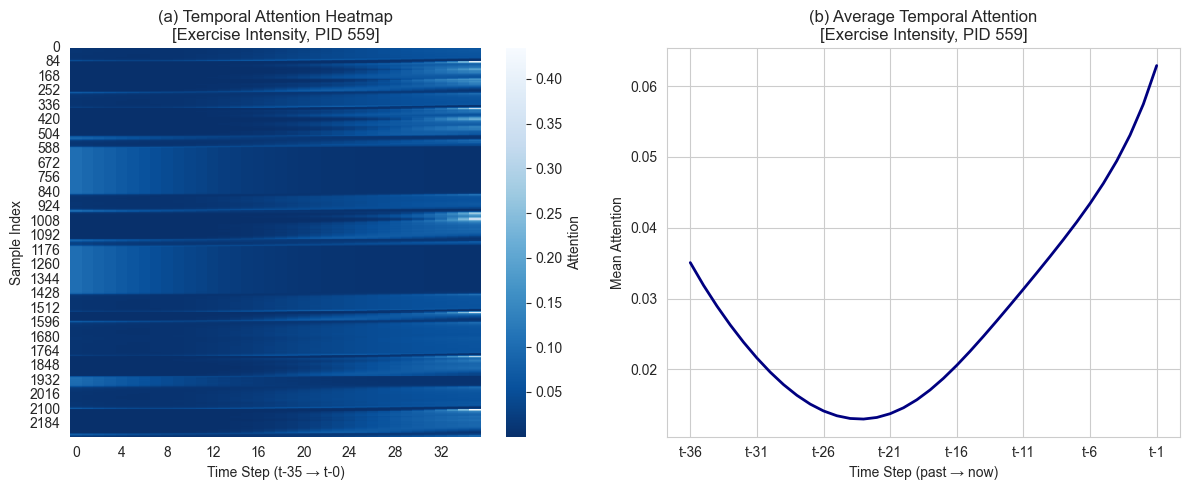

In [21]:
# Temporal attention visualization
# 可视化某个模态的时间注意力分布,展示了模型在预测时“关注”历史输入的哪些时间步
# 用热力图显示每个样本的时间注意力分布，以及用折线图展示所有样本在各时间步的平均注意力

pid = "559"
T = 36
modal_id = 4   # index of FEATURES(0-6)

# Feature keys
FEATURES = ['glucose', 'meal_carbs', 'insulin_bolus', 'insulin_basal', 'exercise_intensity', 'gsr', 'skin_temp']

# Friendly feature names
FEATURE_NAMES = {
    'glucose': 'Blood Glucose',
    'meal_carbs': 'Meal Carbohydrates',
    'insulin_bolus': 'Insulin Bolus',
    'insulin_basal': 'Basal Insulin',
    'exercise_intensity': 'Exercise Intensity',
    'gsr': 'Galvanic Skin Response',
    'skin_temp': 'Skin Temperature'
}

# Get selected feature name
feature_key = FEATURES[modal_id]
feature_name = FEATURE_NAMES[feature_key]

# Load attention weights
attn = np.load(f"weights/modal_{modal_id+1}_temp_weights_pid{pid}_full.npy").squeeze()

# Compute mean attention over samples
mean_attn = attn.mean(axis=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})

# Figure 1: Heatmap
sns.heatmap(
    attn,
    cmap="Blues_r",
    ax=axes[0],
    xticklabels=4,
    cbar_kws={"label": "Attention"}
)
axes[0].set_title(f"(a) Temporal Attention Heatmap\n[{feature_name}, PID {pid}]")
axes[0].set_xlabel("Time Step (t-35 → t-0)")
axes[0].set_ylabel("Sample Index")

# Figure 2: Mean attention line plot
axes[1].plot(range(T), mean_attn, color="navy", linewidth=2)
axes[1].set_xticks([0, 5, 10, 15, 20, 25, 30, 35])
axes[1].set_xticklabels([f"t-{T-i}" for i in [0,5,10,15,20,25,30,35]])
axes[1].set_xlabel("Time Step (past → now)")
axes[1].set_ylabel("Mean Attention")
axes[1].set_title(f"(b) Average Temporal Attention\n[{feature_name}, PID {pid}]")
axes[1].grid(True)

plt.tight_layout()
plt.show()


C:\Users\12905\AppData\Local\Temp\ipykernel_24556\2435773125.py:59: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(


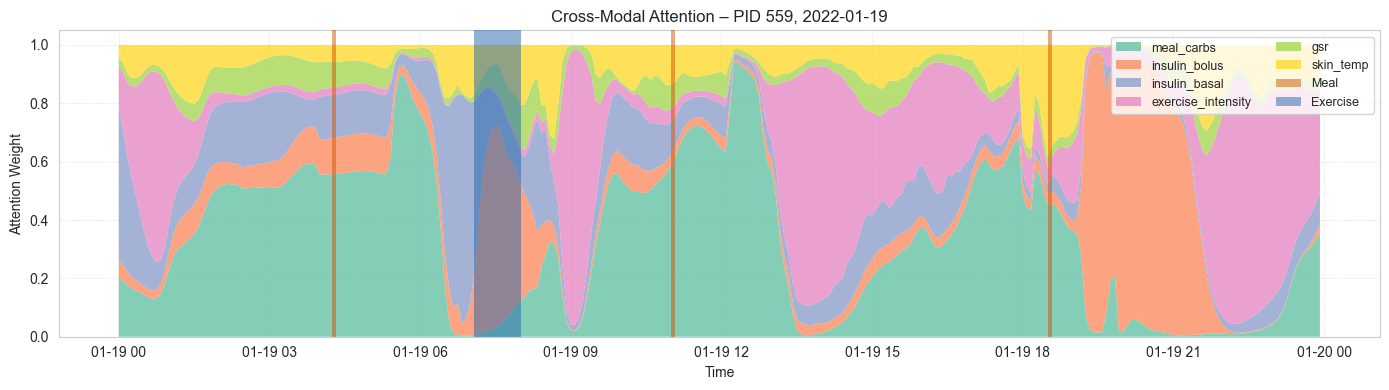

In [19]:
# Cross-modal attention visualization
# 对某一天的样本用堆叠面积图stacked area plot,展示注意力随时间的变化，并用半透明区域标注当天的meal和exercise事件

pid = "559"
example_day_idx = 1
xattn_path = f"weights/cma_all_softmax_pid{pid}_full.npy"
modal_json = f"weights/xattn_modal_names_pid{pid}.json"
events_path = f"processed/patient_{pid}_events.csv"
df_path = f"processed/patient_{pid}_test_std.csv"

# Load data
attn = np.load(xattn_path).squeeze(1)  # (N, M-1)
with open(modal_json, "r") as f:
    modal_names = json.load(f)

df = pd.read_csv(df_path, index_col=0, parse_dates=True)
events = pd.read_csv(events_path, index_col=0, parse_dates=True)

# Align attention with test data length
df = df.iloc[-len(attn):]
events = events.iloc[-len(attn):]
attn_df = pd.DataFrame(attn, columns=modal_names, index=df.index)

# Select one day
example_day = attn_df.index.normalize().unique()[example_day_idx]
attn_day = attn_df[attn_df.index.normalize() == example_day]
events_day = events.loc[attn_day.index]

# Skip if too few samples
if len(attn_day) < 20:
    print("Insufficient data, please try another day")
else:
    fig, ax = plt.subplots(figsize=(14, 4))

    # Define event styles: only meal and exercise
    event_styles = {
        "meal_flag":     {"color": "#D35400", "label": "Meal",     "alpha": 0.5},
        "exercise_flag": {"color": "#2166AC", "label": "Exercise", "alpha": 0.5},
    }

    # Plot stacked attention
    set2_colors = plt.cm.Set2.colors
    ax.stackplot(
        attn_day.index,
        attn_day.values.T,
        labels=modal_names,
        colors=set2_colors[:len(modal_names)],
        alpha=0.8,
        linewidth=0,
        edgecolor='none',
        zorder=1
    )

    # Highlight event flags
    used_labels = set()
    for flag, style in event_styles.items():
        mask = events_day[flag] == 1
        for t in attn_day.index[mask]:
            ax.axvspan(
                t,
                t + pd.Timedelta(minutes=5),
                color=style["color"],
                alpha=style["alpha"],
                edgecolor="none",
                linewidth=0,
                zorder=3,
                label=style["label"] if style["label"] not in used_labels else None
            )
        used_labels.add(style["label"])

    # Format plot
    ax.set_title(f"Cross-Modal Attention – PID {pid}, {example_day.date()}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Attention Weight")
    ax.grid(True, linestyle='--', alpha=0.3)

    # Unique legend
    handles, labels = ax.get_legend_handles_labels()
    from collections import OrderedDict
    unique = OrderedDict()
    for h, l in zip(handles, labels):
        if l and l not in unique:
            unique[l] = h
    ax.legend(unique.values(), unique.keys(), loc='upper right', ncol=2, fontsize=9)

    plt.tight_layout()
    plt.show()


Loaded z_fused: shape = (2256, 64)
[Q1] Clustering done (k=4), Silhouette Score = 0.3164
[✓] State file saved to weights/state_pid559_K4.npy


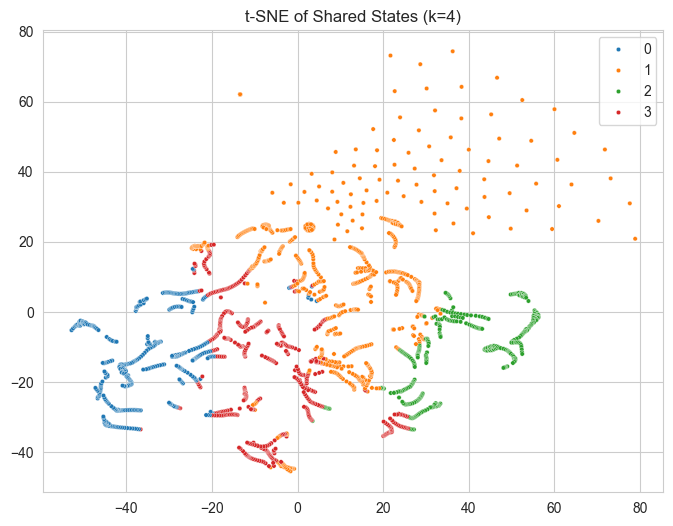

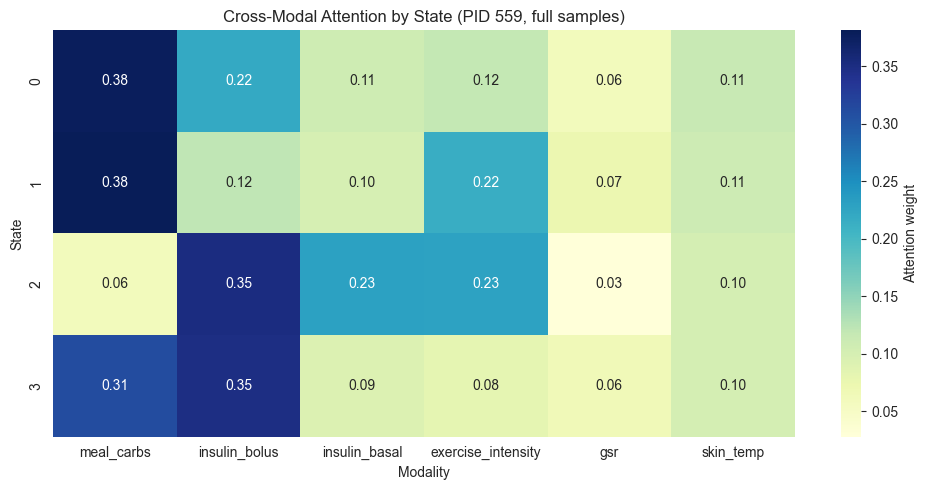

In [5]:
# Clustering & state-level CMA heatmap
# 它对提取的共享表示 z_fused 进行了 KMeans 聚类和 t-SNE 降维可视化，然后计算每个聚类（即“状态”）对应的跨模态注意力平均值，并绘制出按状态分组的模态依赖热力图。

PID = "559"  # patient ID
MODEL_TAG = ""  # optional model suffix
N_CLUSTERS = 4  # number of clusters

# 1 Load z_fused
z_fused = np.load(f"weights/fused_pid{PID}{'_' + MODEL_TAG if MODEL_TAG else ''}.npy")
print(f"Loaded z_fused: shape = {z_fused.shape}")

# 2 Clustering analysis
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(z_fused)
sil_score = silhouette_score(z_fused, cluster_labels)
print(f"[Q1] Clustering done (k={N_CLUSTERS}), Silhouette Score = {sil_score:.4f}")

# Save clustering results for later visualization
state_path = f"weights/state_pid{PID}_K{N_CLUSTERS}.npy"
np.save(state_path, cluster_labels)
print(f"[✓] State file saved to {state_path}")

# 3 Dimensionality reduction (t-SNE)
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_fused)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=cluster_labels, palette='tab10', s=10)
plt.title(f"t-SNE of Shared States (k={N_CLUSTERS})")
plt.savefig(f"tsne_shared_states_pid{PID}.png")
plt.show()

# Cross-modal attention heatmap per state

# Load state labels and attention weights
state_t = np.load(state_path)  # (N,)
xattn = np.load(f"weights/cma_all_softmax_pid{PID}_full.npy")  # (N, M-1)
xattn = xattn.squeeze(axis=1)

# Load modality names
with open(f"weights/xattn_modal_names_pid{PID}.json", "r") as f:
    modal_names = json.load(f)

# Create DataFrame
df = pd.DataFrame(xattn, columns=modal_names)
df["state"] = state_t

# Compute mean attention per state
attn_by_state = df.groupby("state")[modal_names].mean()

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(attn_by_state, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Attention weight'})
plt.title(f"Cross-Modal Attention by State (PID {PID}, full samples)")
plt.xlabel("Modality")
plt.ylabel("State")
plt.tight_layout()
plt.show()


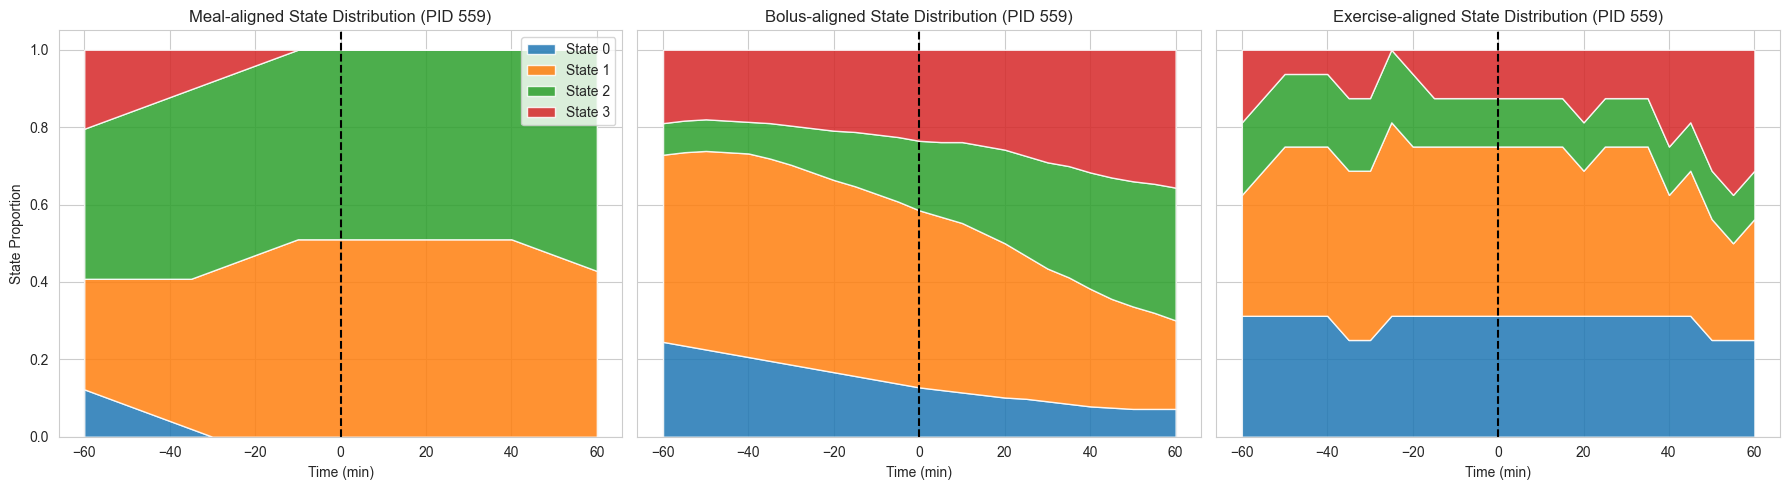

In [4]:
# Event-aligned state distribution plots
# 它对聚类结果中的潜在状态分布，在特定事件（如餐食、注射、运动）前后进行对齐分析，绘制出事件前后各状态占比随时间变化的堆叠曲线图，从而揭示潜在状态与事件之间的动态关联。
pid = "559"
K = 4
window_min = 60
step_min = 5
event_list = ["exercise", "bolus", "meal"]
def plot_event_aligned_state_distribution(pid, event_name, state_K=4, window_min=60, step_min=5):
    # Load data
    df = pd.read_csv(f"processed/patient_{pid}_test_std.csv", index_col=0, parse_dates=True)
    state_t = np.load(f"weights/state_pid{pid}_K{state_K}.npy")
    df = df.iloc[-len(state_t):].copy()
    df["state"] = state_t

    # Detect events
    if event_name == "bolus":
        events = df[df["insulin_bolus"] > 0.1].index
    elif event_name == "exercise":
        events = df[df["exercise_intensity"] > 0.35].index
    elif event_name == "meal":
        events = df[df["meal_event"] > 0].index
    else:
        raise ValueError("Unknown event")

    # Build aligned window
    half_steps = window_min // step_min
    total_steps = half_steps * 2 + 1
    time_ticks = np.arange(-window_min, window_min + step_min, step_min)

    aligned = []
    for t0 in events:
        idx = df.index.get_loc(t0)
        if idx - half_steps < 0 or idx + half_steps >= len(df):
            continue
        aligned.append(df.iloc[idx - half_steps : idx + half_steps + 1]["state"].values)

    if len(aligned) == 0:
        print(f"[{event_name}] No valid event windows, skipped")
        return None

    aligned = np.stack(aligned)  # shape: (E, T)

    # Compute state proportions at each time step
    state_props = []
    for s in range(state_K):
        mask = (aligned == s)
        prop = mask.mean(axis=0)
        state_props.append(prop)

    return time_ticks, state_props

# Plot for three event types
titles = ["Meal-aligned", "Bolus-aligned", "Exercise-aligned"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, event in enumerate(event_list):
    result = plot_event_aligned_state_distribution(pid, event, state_K=K, window_min=window_min, step_min=step_min)
    if result is not None:
        time_ticks, state_props = result
        axes[i].stackplot(time_ticks, state_props, labels=[f"State {s}" for s in range(K)], alpha=0.85)
        axes[i].axvline(0, color='k', linestyle='--')
        axes[i].set_title(f"{titles[i]} State Distribution (PID {pid})")
        axes[i].set_xlabel("Time (min)")
        if i == 0:
            axes[i].set_ylabel("State Proportion")
        axes[i].grid(True)

axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()
